# **환율 기반 금융위기 조기 감지 시스템**

> 환율 변동률(volatility)을 기반으로 **위험 임계치**를 넘으면 금융위기 가능성을 조기 경고하는 시스템



: **환율 변동성이 갑자기 커지면 금융위기가 올 수도 있다**는 가정 하에,
- 세 가지 방식
  - rule-based
  - anomaly-based
  - classification-based <br>

으로 조기경고(early warning) 신호를 뽑아내는 구조

<br>

1. 변동률(Volatility) 계산 및 임계치 설정
- 환율 시계열의 로그수익률을 계산
  - 로그수익률
    - 시계열 데이터(여기서는 환율)가 한 시점에서 다음 시점으로 얼마나 ‘비율적으로’ 변했는지를 연속 복리(compounded) 기준으로 계산한 값
- 일정 윈도우(예: 30일)로 이동 표준편차(rolling volatility)를 구함
- 역사적 분포(예: 상위 90~95백분위)로 임계치(threshold)를 정의

<br>

2. 위험 경고 모델

- 단순 룰 기반: volatility > threshold 일 때 경고

- 머신러닝 분류 모델: 과거 위기 이벤트(라벨 1) vs 평시(0)를 학습해, 미래 (t+1) 시점의 위기 여부를 예측


| 경고 방식     | 어떤 신호인가                        | 해석 예시                      |
| --------- | ------------------------------ | -------------------------- |
| 룰 기반      | 변동성이 평소보다 지나치게 커졌다             | “이번 달 환율 요동이 상위 5% 이상입니다!” |
| 이상치 탐지    | 변동성 패턴 자체가 평소와 다르게 비정상적으로 보인다  | “변동성 분포가 갑자기 달라졌습니다!”      |
| 분류 모델(확률) | 과거 위기 패턴과 비슷한 변동성 양상을 보인다 (확률) | “위기일 확률이 30%를 넘었습니다!”      |


In [1]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    roc_auc_score,
    auc)
import seaborn as sns
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/MyDrive/LikeLion/DataTone/exchange_final.csv")

data.head()

,Unnamed: 0,TIME,원/달러환율,한국 장기 시장 금리,미국 장기 시장 금리,중국 장기 시장 금리,한국 단기 시장 금리,미국 단기 시장 금리,중국 단기 시장 금리,전체 수출 총액,...,한국 중앙정부 부채 비율,미국 중앙정부 부채 비율,한국 10년 채권수익률,미국 10년 채권수익률,한국 인플레이션율,미국 인플레이션율,인플레이션 격차,실질GDP,실질GDP성장률,vix
0,0,2000-01-01,1130.32,NaN,6.66,NaN,7.28,5.95,2.72,12162425,...,NaN,33.267642,NaN,NaN,NaN,NaN,NaN,883159.302102,NaN,24.95
1,1,2000-02-01,1129.29,NaN,6.52,NaN,7.13,6.01,2.73,12676042,...,NaN,34.865592,NaN,NaN,NaN,NaN,NaN,876860.243167,NaN,23.37
2,2,2000-03-01,1115.75,NaN,6.26,NaN,7.00,6.14,2.64,14429703,...,NaN,36.463543,NaN,NaN,NaN,NaN,NaN,870598.143103,NaN,24.11
3,3,2000-04-01,1110.01,NaN,5.99,NaN,7.06,6.28,2.64,13522040,...,NaN,38.061493,NaN,NaN,NaN,NaN,NaN,864372.677584,NaN,26.20
4,4,2000-05-01,1121.37,NaN,6.44,NaN,7.14,6.71,2.57,14636755,...,NaN,39.659444,NaN,NaN,NaN,NaN,NaN,858183.526068,NaN,23.65


In [5]:
m2 = pd.read_csv('/content/drive/MyDrive/LikeLion/DataTone/M2_2000_2024.CSV', encoding='cp949')

# 'Jan-00' → datetime으로 변환 (월 초 날짜 기준)
m2['TIME'] = pd.to_datetime(m2['TIME'], format='%Y-%m')

# 확인
print(m2.head())

        TIME        M2  증가율
0 2000-01-01  674.7231 -0.8
1 2000-02-01  677.6103  0.4
2 2000-03-01  685.3970  1.1
3 2000-04-01  689.5531  0.6
4 2000-05-01  688.6894 -0.1


In [6]:
data['TIME'] = pd.to_datetime(data['TIME'])

# 병합
df_merged = pd.merge(data, m2, on='TIME', how='left')

## **1. 데이터 준비 및 volatility 계산**


### 환율 변동성(volatility) 계산
- log_ret: 오늘 환율/어제 환율의 로그수익률
- rolling(12).std(): 과거 12개월(또는 기간) 동안 수익률 표준편차 → 연환산(×√12)
→ volatility가 높다는 건, “환율이 짧은 기간에 크게 요동쳤다”는 뜻
- volatility는 로그수익률의 이동 표준편차에 연환산(sqrt(252))을 곱해 구한다.

In [7]:
# 1. 환율 데이터 준비 (과거)
df = df_merged.copy()
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME').sort_index()
df['rate'] = df['원/달러환율']

# 2. 변동성 계산: log 수익률 → 12개월 rolling std → annualized
df['log_ret'] = np.log(df['rate'] / df['rate'].shift(1))
window = 12
df['volatility'] = df['log_ret'].rolling(window).std() * np.sqrt(12)

# 3. 위기 구간 수동 정의
crisis_periods = [
    ('2000-03', '2002-10'),
    ('2008-09', '2009-03'),
    ('2020-03', '2021-06'),
    ('2022-03', '2023-07')
]
def label_crisis(ts):
    ym = ts.strftime('%Y-%m')
    for start, end in crisis_periods:
        if start <= ym <= end:
            return 1
    return 0
df['crisis'] = df.index.to_series().apply(label_crisis)
df = df.dropna(subset=['volatility', 'crisis'])


## **2. 데이터 분할 + 모델 학습**

In [8]:
# t 시점 volatility로 t+1 위기 예측
X = df[['volatility']]
y = df['crisis'].shift(-1).fillna(0).astype(int)

# 학습/테스트 분할 (시계열 유지)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 데이터 불균형 보정 (SMOTE)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# RandomForest 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

## **3. 최적 임계치 계산 (PR curve 기반)**

In [9]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# 1) 확률 얻기
probs = rf.predict_proba(X_test)[:, 1]

# precision, recall, thresholds 계산
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# 1) F1 점수 전체 계산 (길이 N+1)
f1_scores = 2 * (precision * recall) / (precision + recall)

# 2) thresholds에 대응하는 F1 점수만 추출 (맨 끝항 버리기)
f1_for_thr = f1_scores[:-1]       # 길이 N

# [0.1, 0.9] 사이에서만 탐색
mask = (thresholds >= 0.1) & (thresholds <= 0.9)
best_idx = np.argmax(f1_for_thr[mask])
best_thr = thresholds[mask][best_idx]


print(f'F1 최적화 임계치: {best_thr:.2f}, F1: {f1_for_thr[best_idx]:.3f}')

F1 최적화 임계치: 0.11, F1: 0.711


<ipython-input-9-5d19274f78d6>:11: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


## **4. 다개월 예측 실행**

In [10]:
from dateutil.relativedelta import relativedelta

# 예측 환율 데이터 로드
comp = pd.read_csv('/content/drive/MyDrive/LikeLion/DataTone/future_12_months_forecast.csv')

# 'Dec-24' 형식 파싱: %b = 영어 약어(month), %y = 두 자리 연도
comp['TIME'] = pd.to_datetime(comp['TIME'], format='%b-%y')

# 인덱스로 설정하고 정렬
comp = comp.set_index('TIME').sort_index()

# 과거 + 예측 환율 통합
rate_all = pd.concat([
    df['rate'],
    comp['Predicted_Exchange_Rate'].rename('rate')
]).sort_index()

comp = comp.sort_index()

results = []

for ts in comp.index:
    # (1) ts 시점까지 슬라이스
    s = rate_all.loc[:ts]

    # (2) 로그수익률 및 volatility 계산
    log_ret = np.log(s / s.shift(1))
    vol = log_ret.rolling(window).std() * np.sqrt(12)

    # (3) 룰 기반 경고 및 이상치 탐지
    thr_rule = vol.quantile(0.95)
    df_slice = pd.DataFrame({'volatility': vol})
    df_slice['rule_warning'] = (df_slice['volatility'] > thr_rule).astype(int)

    iso = IsolationForest(contamination=0.05, random_state=42)

    # (3) 이상치 탐지
    anom = iso.fit_predict(df_slice[['volatility']].dropna())
    anom_s = pd.Series(anom, index=df_slice['volatility'].dropna().index)

    # 중복 타임스탬프 처리: 먼저 첫 번째 값만 남겨서 unique index 생성
    anom_unique = anom_s.groupby(level=0).first()
    # df_slice.index(중복 포함)로 재색인 → 없으면 0, 있으면 -1 또는 1
    df_slice['anomaly_warning'] = (
        anom_unique
        .reindex(df_slice.index, fill_value=0)
        .astype(int)
    )

    # (4) 예측
    current_vol = df_slice['volatility'].iloc[-1]
    from sklearn.calibration import CalibratedClassifierCV
    calibrated_rf = CalibratedClassifierCV(rf, cv=5, method='isotonic')
    calibrated_rf.fit(X_train, y_train)
    prob_next = calibrated_rf.predict_proba([[current_vol]])[0,1]


    class_thr    = 0.7
    class_warn   = (prob_next > class_thr)

    results.append({
      'forecast_month':   (ts + relativedelta(months=1)).strftime('%b-%y'),
      'volatility':       current_vol,
      'rule_warn':        bool(df_slice['rule_warning'].iloc[-1]),
      'anomaly_warn':     bool(df_slice['anomaly_warning'].iloc[-1]),
      'crisis_prob':      prob_next,
      'class_warn':       bool(class_warn)      # ← 여기에 임계치 적용
    })

res_df = pd.DataFrame(results).set_index('forecast_month')


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

In [11]:
print("예측 대상 마지막 달:", comp.index.max())
print("→ 생성된 예측:", res_df.index)


예측 대상 마지막 달: 2025-12-01 00:00:00
→ 생성된 예측: Index(['Jan-25', 'Feb-25', 'Mar-25', 'Apr-25', 'May-25', 'Jun-25', 'Jul-25',
       'Aug-25', 'Sep-25', 'Oct-25', 'Nov-25', 'Dec-25', 'Jan-26'],
      dtype='object', name='forecast_month')


In [12]:
res_df

,volatility,rule_warn,anomaly_warn,crisis_prob,class_warn
forecast_month,,,,,
Jan-25,0.074418,False,True,0.154519,False
Feb-25,0.074490,False,True,0.154519,False
Mar-25,0.074547,False,True,0.154519,False
Apr-25,0.069403,False,True,0.805001,True
May-25,0.069297,False,True,0.805001,True
Jun-25,0.068443,False,True,0.290470,False
Jul-25,0.068417,False,True,0.317137,False
Aug-25,0.063995,False,True,0.566370,False
Sep-25,0.061364,False,True,0.609703,False


## **해석!**
**1. volatility**
- 해당 월까지의 연환산(log 수익률의 12개월 이동 표준편차) 변동성.
- 예: Jan-25의 0.0744는 약 7.44% 연간 변동성을 의미

**2. rule_warn**
- 룰 기반 경고
- 조건: volatility > vol.quantile(0.95)
- **True면** 이 월의 변동성이 과거 분포 상위 5%를 넘었음을 알린다.
- **False면** 이 월의 변동성이 과거 분포 상위 5%를 넘지 않았음을 알린다.

**3. anomaly_warn**
- 이상치 탐지 경고
- 조건: IsolationForest(contamination=0.05)로 학습한 모델이
  - “비정상”으로 분류한 경우 **True**
  - "정상"으로 분류한 경우 **Fasle**

**4. crisis_prob**
- 분류 모델(랜덤포레스트) 예측 확률
- “다음 달(t+1)에 위기일 확률”을 0~1 사이로 표시
- 예: Apr-25의 0.8050은 80.5% 확률로 위기를 예측합니다.

**5. class_warn**
- 분류 기반 경고
- 조건: crisis_prob > class_thr (임계치 0.7) 일 때 **True**
- 위 표에서는 class_thr가 0.7라면 **Apr-25, May-25**만 **True**

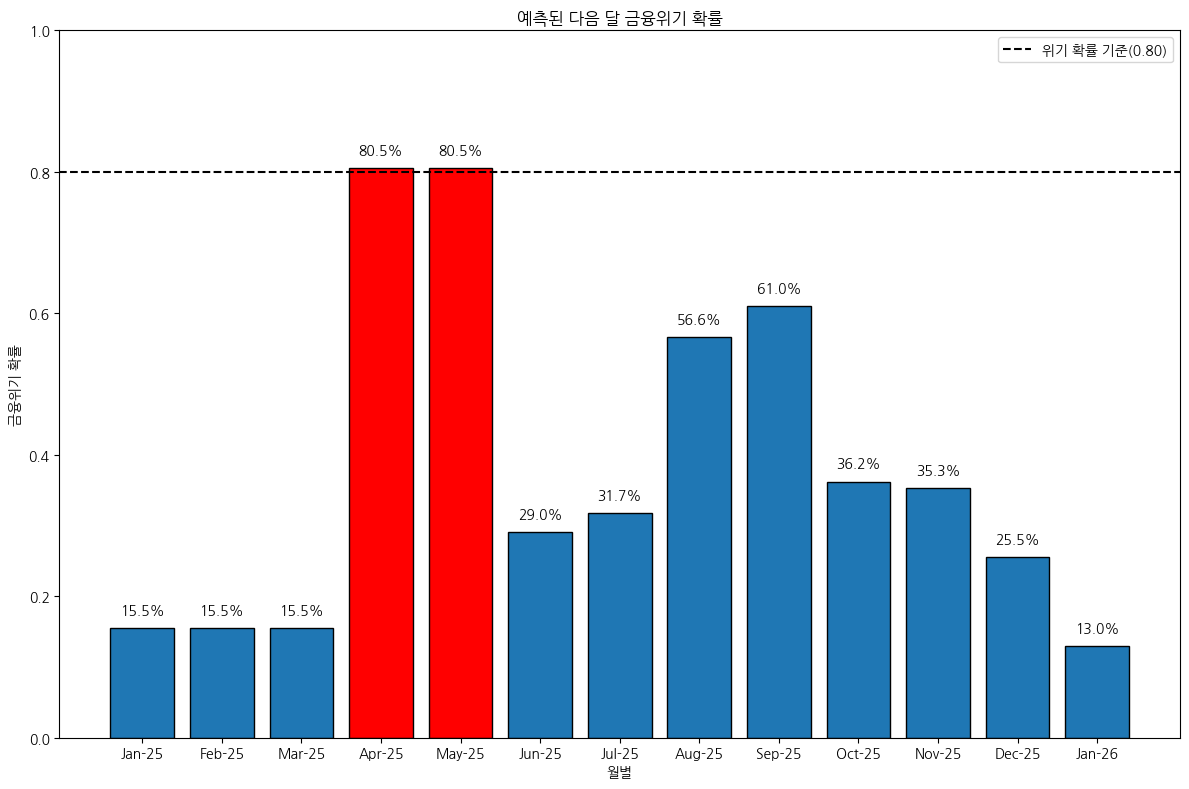

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

# 1) 막대별 색상 결정: 확률 > 임계치 → red, 아니면 blue
custom_thr = 0.8
colors = ['red' if p > custom_thr else 'tab:blue'
          for p in res_df['crisis_prob']]

# 2) 바 차트 그리기
bars = ax.bar(res_df.index, res_df['crisis_prob'],
              color=colors, edgecolor='black')

# 3) 임계선
ax.axhline(custom_thr, linestyle='--', color='black',
           label=f'위기 확률 기준({custom_thr:.2f})')

# 4) 레이블, 타이틀, 축 설정
ax.set_title('예측된 다음 달 금융위기 확률')
ax.set_xlabel('월별')
ax.set_ylabel('금융위기 확률')
ax.set_ylim(0, 1)

# 5) 값 표시
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.02,
            f"{h:.1%}", ha='center')

# 6) 범례 및 레이아웃
ax.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


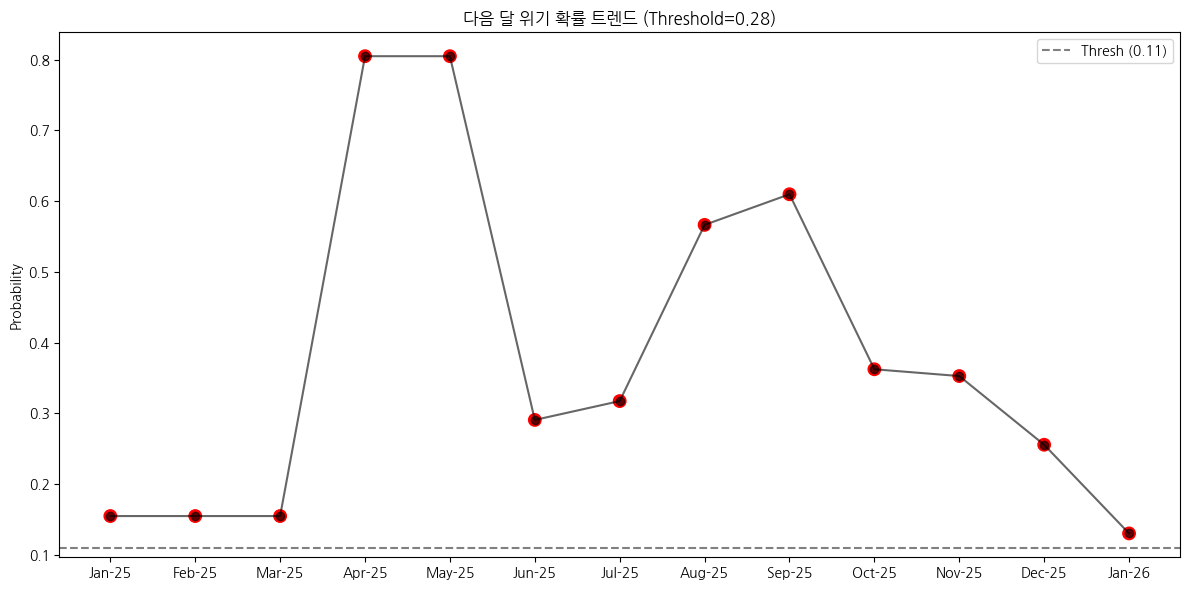

In [14]:
custom_thr = 0.11
colors = ['red' if p > custom_thr else 'blue'
          for p in res_df['crisis_prob']]

fig, ax = plt.subplots(figsize=(12,6))
# 선과 마커
ax.plot(res_df.index, res_df['crisis_prob'], '-o', color='black', alpha=0.6)
# 개별 점 색칠
ax.scatter(res_df.index, res_df['crisis_prob'], color=colors, s=80)
# 임계치 수평선
ax.axhline(custom_thr, linestyle='--', color='gray', label=f'Thresh ({custom_thr:.2f})')

ax.set_ylabel('Probability')
ax.set_title('다음 달 위기 확률 트렌드 (Threshold=0.28)')
ax.legend()
plt.tight_layout()
